In [34]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import dlib
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model

In [35]:
# Load pre-trained MobileNetV2 for segmentation
def load_mobilenetv2():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block_13_expand_relu').output)
    return model

# Function to upload image
def upload_image():
    uploaded_image_path = input("my_pic.jpg")
    img = Image.open(uploaded_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img

# Function to display image
def display_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [36]:
# Function to apply edge operator
def apply_edge_operator(image, operator_name):
    # Convert the image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    if operator_name == 'canny':
        # Apply Canny edge detector
        edges = cv2.Canny(gray, 50, 150)
    elif operator_name == 'sobel_x':
        # Apply Sobel X operator
        edges = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    elif operator_name == 'sobel_y':
        # Apply Sobel Y operator
        edges = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    elif operator_name == 'laplacian':
        # Apply Laplacian operator
        edges = cv2.Laplacian(gray, cv2.CV_64F)
    elif operator_name == 'hsb':
        # Convert image to HSB
        hsb = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
        edges = cv2.Canny(hsb[:, :, 2], 50, 150)
    elif operator_name == 'hsv':
        # Convert image to HSV
        hsv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
        edges = cv2.Canny(hsv[:, :, 2], 50, 150)
    elif operator_name == 'log':
        # Apply Laplacian of Gaussian (LoG) operator
        gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Laplacian(gray_blur, cv2.CV_64F)

    # Display the result
    display_image(np.abs(edges).astype(np.uint8), f"{operator_name.capitalize()} Edge Detection")

    return edges

In [37]:
# Function for face segmentation using SVM
def segment_face_svm(image):
    # Load face detector from dlib
    detector = dlib.get_frontal_face_detector()

    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    if len(faces) == 0:
        print("No face found in the image for SVM segmentation.")
        return None

    # Assume the first detected face is the user's face
    x, y, w, h = faces[0].left(), faces[0].top(), faces[0].width(), faces[0].height()

    # Extract the face region
    face = image.crop((x, y, x + w, y + h))

    return face

In [38]:
# Function for face segmentation using K-Means clustering
def segment_face_kmeans(image):
    # Convert image to numpy array
    img_array = np.array(image)

    # Reshape the image to a 2D array of pixels
    pixels = img_array.reshape((-1, 3))

    # Convert to float type
    pixels = np.float32(pixels)

    # Perform K-Means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8-bit values
    centers = np.uint8(centers)

    # Map the labels to the centers
    segmented_img = centers[labels.flatten()]

    # Reshape back to the original image dimensions
    segmented_img = segmented_img.reshape(img_array.shape)

    return segmented_img

In [39]:
# Function for face segmentation using DeepLabV3
def segment_face_deeplab(image, model):
    # Resize image to fit DeepLabV3 input size
    img_resized = image.resize((224, 224))
    img_array = np.array(img_resized)

    # Preprocess input for DeepLabV3 model
    input_array = preprocess_input(np.expand_dims(img_array, 0))

    # Predict segmentation mask
    predictions = model.predict(input_array)

    # Post-process the segmentation mask
    mask = np.argmax(predictions, axis=-1)[0]

    # Considering only the person class
    mask = np.where(mask == 15, 255, 0).astype(np.uint8)

    # Resize mask to match the original image dimensions
    mask_resized = cv2.resize(mask, (img_array.shape[1], img_array.shape[0]))

    # Overlay the mask on the original image
    segmented_img = cv2.bitwise_and(img_array, img_array, mask=mask_resized)

    return segmented_img

my_pic.jpgmy_pic.jpg


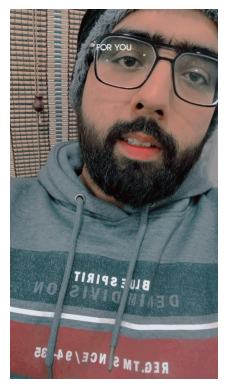

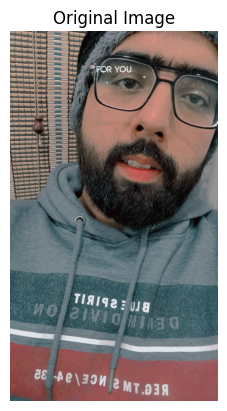

In [40]:
# Example usage
uploaded_image = upload_image()

# Display the original image
display_image(uploaded_image, "Original Image")

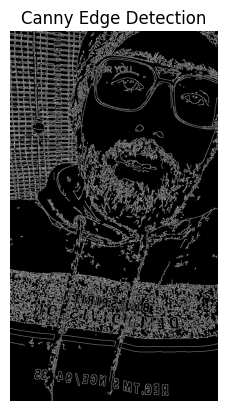

In [41]:
# Apply Canny edge detector and display the result
canny_edges = apply_edge_operator(uploaded_image, 'canny')

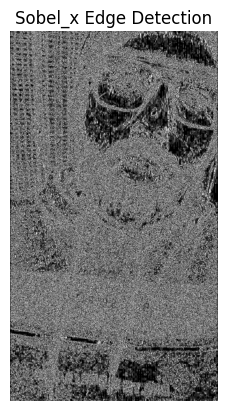

In [42]:
# Apply Sobel X operator and display the result
sobel_x = apply_edge_operator(uploaded_image, 'sobel_x')

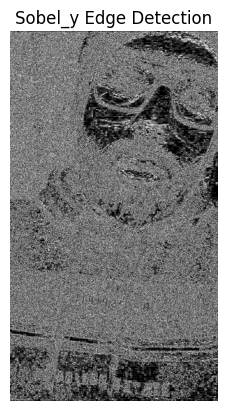

In [43]:
# Apply Sobel Y operator and display the result
sobel_y = apply_edge_operator(uploaded_image, 'sobel_y')


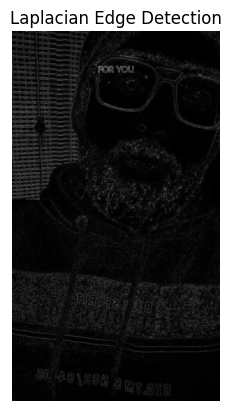

In [44]:
# Apply Laplacian operator and display the result
laplacian = apply_edge_operator(uploaded_image, 'laplacian')

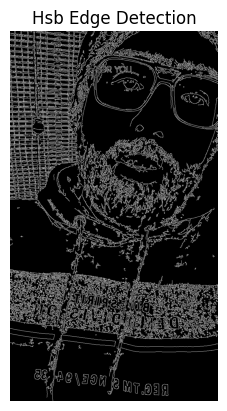

In [45]:
# Convert image to HSB, apply Canny edge detector, and display the result
hsb_edges = apply_edge_operator(uploaded_image, 'hsb')


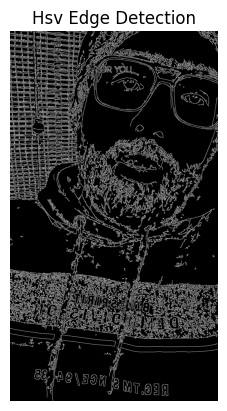

In [46]:
# Convert image to HSV, apply Canny edge detector, and display the result
hsv_edges = apply_edge_operator(uploaded_image, 'hsv')


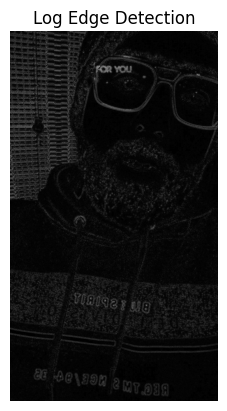

In [47]:
# Apply Laplacian of Gaussian (LoG) operator and display the result
log_edges = apply_edge_operator(uploaded_image, 'log')


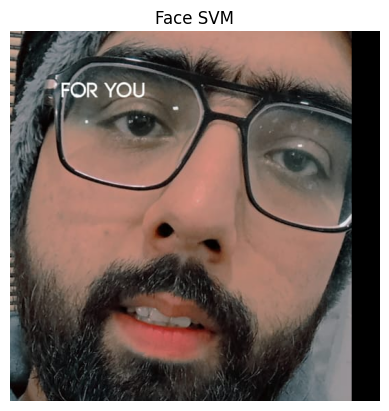

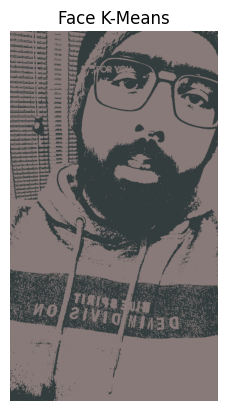

1/1 [==============================] - 1s 693ms/step


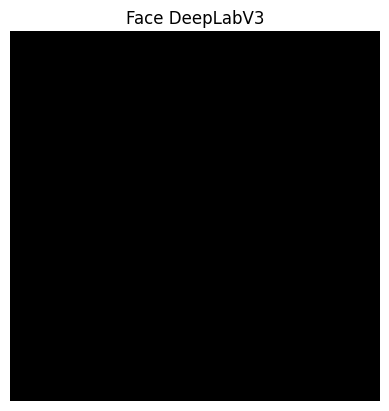

In [48]:
# SVM Face Segmentation and display the result
face_svm = segment_face_svm(uploaded_image)

if face_svm is not None:
    display_image(face_svm, "Face SVM")
else:
    print("Face SVM segmentation failed.")

# K-Means Face Segmentation and display the result
face_kmeans = segment_face_kmeans(uploaded_image)

if face_kmeans is not None:
    display_image(face_kmeans, "Face K-Means")
else:
    print("Face K-Means segmentation failed.")

# DeepLabV3 Face Segmentation and display the result
mobilenetv2_model = load_mobilenetv2()
face_deeplab = segment_face_deeplab(uploaded_image, mobilenetv2_model)

if face_deeplab is not None:
    display_image(face_deeplab, "Face DeepLabV3")
else:
    print("Face DeepLabV3 segmentation failed.")
